# Data Analysis Part Jara

Linking number of edit events since last passing tests to probability of unit tests passing

In [35]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns; sns.set()
from itertools import islice
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression

# Import Data


In [3]:
editEvents = pd.read_csv("../data/df_edit.csv")
testEvents = pd.read_csv("../data/df_test.csv")

### Edit Events

In [4]:
print(f'No of edit events: {len(editEvents)}')
editEvents.tail()
allSessionID=editEvents.sessionID.unique()
print(f'no of sessions: {allSessionID.size} \n')

No of edit events: 497459
no of sessions: 2876 



In [5]:
editEvents["sessionID"].describe()

count                                   497459
unique                                    2876
top       8d0ea603-57cd-4b1f-b3cf-ce39ec9203c7
freq                                     17006
Name: sessionID, dtype: object

### Test Events

In [6]:
print(f'No of test events: {len(testEvents)}')
testEvents.head(5)

No of test events: 3826


,Unnamed: 0,sessionID,timestamp,totalTests,testsPassed
0,3197,006eb9aa-33f1-4e9e-8e74-7c978b58ee4a,2016-05-03 09:32:16,33,33
1,3320,03c83bf2-8938-4a8f-9f58-d52bf3b2eccd,2016-05-10 17:21:18,1,0
2,3321,03c83bf2-8938-4a8f-9f58-d52bf3b2eccd,2016-05-10 17:21:54,26,26
3,3322,03c83bf2-8938-4a8f-9f58-d52bf3b2eccd,2016-05-10 17:28:26,1,1
4,34,0504fbd1-cce2-4431-b4e2-edc63eea1c6d,2016-07-13 20:24:46,21,21


In [7]:
testEvents["sessionID"].describe()

count                                     3826
unique                                     275
top       3696281d-3432-4a49-aee6-207ded3ad6a8
freq                                       334
Name: sessionID, dtype: object

In [8]:
testEvents["totalTests"].describe()

count    3826.000000
mean       88.780972
std       430.785770
min        -1.000000
25%         1.000000
50%         3.000000
75%        21.000000
max      6618.000000
Name: totalTests, dtype: float64

In [9]:
testEvents["testsPassed"].describe()

count    3826.000000
mean       76.577627
std       392.217908
min        -1.000000
25%         0.000000
50%         1.000000
75%        15.000000
max      6090.000000
Name: testsPassed, dtype: float64

# Process Data

In [10]:
# gets all passed tests for sessionID
def get_passed_tests(sessionID):
    allPassedTests = testEvents[(testEvents["sessionID"] == sessionID) 
                        & (testEvents["testsPassed"] > 0)]
    return np.asarray(allPassedTests)

# counts the numbers of edits between a test and the next test
# for our purpose, be aware to only call it with passed tests
def get_nr_edits_between_tests(sessionID, timeFirstTest , timeNextTest):
    result = editEvents[(editEvents["timestamp"] < timeNextTest)
                                 & (editEvents["timestamp"] > timeFirstTest) 
                                 & (editEvents["sessionID"] == sessionID)]
    result = np.asarray(result)
    return len(result)



In [11]:
# number of rows for certain sessionID
# print(editEvents.loc[editEvents['sessionID'] == '03c83bf2-8938-4a8f-9f58-d52bf3b2eccd'])

In [12]:
# total nr sessionID that have a test that failed
# print(f"failed tests: {testEvents.loc[testEvents['testsPassed'] == 0].count()}")

In [13]:
# counts nr of edits from passed test until next test event
# returns a list
def edits_from_pass_to_next_test(sessionID):
    result = []
    resultRow = []
    # get all passed tests of the session 
    allPassedTests = get_passed_tests(sessionID)

    numOfRows = np.size(allPassedTests, 0)
    # iterate over each passed test
    for p in range(numOfRows):
        timePass = allPassedTests[p][2]

        # no following test
        if p == numOfRows-1:
            hasNextTest = False
        else:
            hasNextTest = True
            timeTestNext = allPassedTests[p+1][2]
            resultNext = allPassedTests[p+1][4]

        # for each passed test, get nr of edits until next test
        if hasNextTest:
            nrOfEdits = get_nr_edits_between_tests(sessionID,timePass, timeTestNext)
            print(f'time of pass to append: {timePass}')
            print(f'nr of edits: {nrOfEdits}')
            print(f'result next: {resultNext} \n')
            result.append([sessionID, timePass, timeTestNext, nrOfEdits, resultNext])
            
    return result


In [14]:
#result = edits_from_pass_to_next_test('03c83bf2-8938-4a8f-9f58-d52bf3b2eccd')

In [15]:
# creates a DF with 8 columns
def create_df(resultArray):
    print(f'Length result: {len(resultArray)} \n\n')

    # Create DataFrame
    column_labels = ['sessionID','timePass','timeNext', 'editsUntilNextTest', 'ratio P/T','totalTestsNext', 'testPassedNext' ,'booleanNextTest']
    df = pd.DataFrame(resultArray, columns=column_labels)
    return df;


## Iterate over all sessions and create df

In [16]:
# Creates a DF and returns a list that contains among other things
# the nr of edits from a passing test until the next test event and whether this next test has been successful
def get_edits_tests_list():
    sessionWithPassedTests=0
    sessionWithoutPassedTests=0
    sessionWithPassedTestsButNoNextTest=0
    result=[]
    print(f'time before loop: {datetime.now(tz=None)} \n')
    for index, row in testEvents.iterrows():
        if(row["testsPassed"] > 0):
            sessionWithPassedTests+=1
            #has next test
            if((index+1 < len(testEvents)) and (testEvents.iloc[index+1].sessionID == row["sessionID"])):
                item=[]
                timestampNext=testEvents.iloc[index+1].timestamp
                totalTestsNext=testEvents.iloc[index+1].totalTests
                passedTestNext=testEvents.iloc[index+1].testsPassed
                nrOfEdits=get_nr_edits_between_tests(row["sessionID"], row["timestamp"], timestampNext)
                if(passedTestNext == 0):
                    resultTestNextBoolean = 0
                else:
                    resultTestNextBoolean = 1
                if(totalTestsNext != 0):
                    ratioPT = (passedTestNext/totalTestsNext)
                else:
                    ratioPT = 0
                item.append(row["sessionID"])
                item.append(row["timestamp"])
                item.append(timestampNext)
                item.append(nrOfEdits)
                item.append(float(ratioPT))
                item.append(int(totalTestsNext))
                item.append(int(passedTestNext))
                item.append(int(resultTestNextBoolean))
                result.append(item)
            else:
                sessionWithPassedTestsButNoNextTest+=1
        else:
            sessionWithoutPassedTests+=1
    print(f'with passed: {sessionWithPassedTests}')
    print(f'with passed test but no next test: {sessionWithPassedTestsButNoNextTest}')
    print(f'without passed test: {sessionWithoutPassedTests}')
    print(f'total: {sessionWithoutPassedTests+sessionWithPassedTests}')
    print(f'time after loop and df: {datetime.now(tz=None)} \n')
    
    print(result[0])
    print(result[1])
    print(result[2])

    
    return result


In [17]:
edits_tests= get_edits_tests_list()

time before loop: 2020-05-22 09:51:32.518389 

with passed: 2565
with passed test but no next test: 208
without passed test: 1261
total: 3826
time after loop and df: 2020-05-22 09:55:36.165365 

['03c83bf2-8938-4a8f-9f58-d52bf3b2eccd', '2016-05-10 17:21:54', '2016-05-10 17:28:26', 39, 1.0, 1, 1, 1]
['068370ce-c891-45d8-8255-8c9ea63f3b43', '2016-07-13 18:49:28', '2016-07-13 18:51:53', 15, 1.0, 21, 21, 1]
['068370ce-c891-45d8-8255-8c9ea63f3b43', '2016-07-13 18:51:53', '2016-07-13 18:53:04', 3, 1.0, 21, 21, 1]


In [79]:
create_df(edits_tests)

Length result: 2357 




,sessionID,timePass,timeNext,editsUntilNextTest,ratio P/T,totalTestsNext,testPassedNext,booleanNextTest
0,03c83bf2-8938-4a8f-9f58-d52bf3b2eccd,2016-05-10 17:21:54,2016-05-10 17:28:26,39,1.000000,1,1,1
1,068370ce-c891-45d8-8255-8c9ea63f3b43,2016-07-13 18:49:28,2016-07-13 18:51:53,15,1.000000,21,21,1
2,068370ce-c891-45d8-8255-8c9ea63f3b43,2016-07-13 18:51:53,2016-07-13 18:53:04,3,1.000000,21,21,1
3,068370ce-c891-45d8-8255-8c9ea63f3b43,2016-07-13 18:53:04,2016-07-13 18:53:20,1,1.000000,21,21,1
4,068370ce-c891-45d8-8255-8c9ea63f3b43,2016-07-13 18:53:20,2016-07-13 18:53:27,0,1.000000,21,21,1
...,...,...,...,...,...,...,...,...
2352,f6f18876-c00c-4513-a8c8-f927e3b42d23,2017-02-08 07:32:43,2017-02-08 07:33:45,9,1.000000,21,21,1
2353,f6f18876-c00c-4513-a8c8-f927e3b42d23,2017-02-08 07:33:45,2017-02-08 07:41:03,6,1.000000,21,21,1
2354,fa4a1e32-d8a9-4fce-a57e-0aec4d6a25bc,2016-09-22 13:43:57,2016-09-22 13:45:37,0,0.000000,478,0,0
2355,fa4a1e32-d8a9-4fce-a57e-0aec4d6a25bc,2016-09-22 13:46:16,2016-09-22 14:02:31,0,0.993724,478,475,1


# Visualize Data

In [18]:
#calculate avg 
print(len(edits_tests))
edits_tests_array = np.asarray(edits_tests, dtype='O')
nrEventsTest = edits_tests_array[:, 4:6]
nrOfEvents = edits_tests_array[:,3]
testPass = edits_tests_array[:,4]

#sort ascending to nr of events
nrEventsTestSorted = sorted(nrEventsTest, key=lambda entry: entry[0]) 

#chunk size 200 = 12 chunks
chunkSize = math.ceil(int(len(nrOfEvents))/200)
print(f'chunk size: {chunkSize}')

chunk1, chunk2, chunk3, chunk4, chunk5, chunk6, chunk7, chunk8, chunk9, chunk10,chunk11, chunk12 = np.array_split(nrEventsTestSorted, chunkSize)
print(f'first chunk len: {len(chunk1)}')
print(f'last chunk len: {len(chunk12)}')

fails=[]
fails.append(np.count_nonzero(chunk1[:,1] == 0))
fails.append(np.count_nonzero(chunk2[:,1] == 0))
fails.append(np.count_nonzero(chunk3[:,1] == 0))
fails.append(np.count_nonzero(chunk4[:,1] == 0))
fails.append(np.count_nonzero(chunk5[:,1] == 0))
fails.append(np.count_nonzero(chunk6[:,1] == 0))
fails.append(np.count_nonzero(chunk7[:,1] == 0))
fails.append(np.count_nonzero(chunk8[:,1] == 0))
fails.append(np.count_nonzero(chunk9[:,1] == 0))
fails.append(np.count_nonzero(chunk10[:,1] == 0))
fails.append(np.count_nonzero(chunk11[:,1] == 0))
fails.append(np.count_nonzero(chunk12[:,1] == 0))
print(fails)

passList=[]
passList.append(np.count_nonzero(chunk1[:,1] == 1))
passList.append(np.count_nonzero(chunk2[:,1] == 1))
passList.append(np.count_nonzero(chunk3[:,1] == 1))
passList.append(np.count_nonzero(chunk4[:,1] == 1))
passList.append(np.count_nonzero(chunk5[:,1] == 1))
passList.append(np.count_nonzero(chunk6[:,1] == 1))
passList.append(np.count_nonzero(chunk7[:,1] == 1))
passList.append(np.count_nonzero(chunk8[:,1] == 1))
passList.append(np.count_nonzero(chunk9[:,1] == 1))
passList.append(np.count_nonzero(chunk10[:,1] == 1))
passList.append(np.count_nonzero(chunk11[:,1] == 1))
passList.append(np.count_nonzero(chunk12[:,1] == 1))

print(passList)




2357
chunk size: 12
first chunk len: 197
last chunk len: 196
[11, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[150, 159, 37, 0, 0, 0, 0, 68, 74, 44, 101, 91]


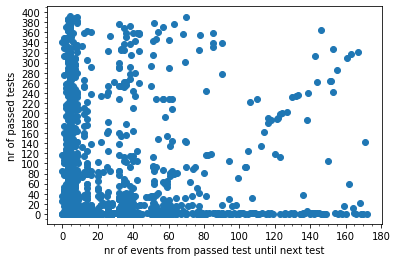

Length result: 2357 




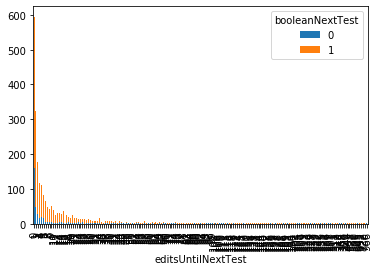

In [19]:
edits_tests_array = np.asarray(edits_tests)

nrOfEvents = edits_tests_array[:,3]
testPass = edits_tests_array[:,4]
start = max(nrOfEvents)
end = min(nrOfEvents)


#plot 1
fig, ax = plt.subplots()
ax.scatter(nrOfEvents, testPass)
plt.xlabel('nr of events from passed test until next test')
plt.ylabel('nr of passed tests')
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(5))
#yaxis
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.show()


#plot 3
df = create_df(edits_tests)
df.groupby(['editsUntilNextTest','booleanNextTest']).size().unstack().plot(kind='bar',stacked=True)



## Model building Regression
Predict the test passing by the number of edits since the last passed test

In [20]:
df_edit_tests = create_df(edits_tests)
grouped = df_edit_tests.groupby(['sessionID'])
sessionStarts = grouped.agg({'timePass':np.min}).to_dict()

Length result: 2357 




In [29]:
edits_tests_array = np.array(edits_tests, dtype="O")
edits_ratio_array = edits_tests_array[:,3:5]
edits_ratio_list = edits_ratio_array.tolist()
x = edits_tests_array[:,3]
y = edits_tests_array[:,4]
print(type(x[2]))
print(type(y[2]))

frame = pd.DataFrame(edits_ratio_list, columns=['edits','success'])
print(frame.head(20))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


<class 'int'>
<class 'float'>
    edits   success
0      39  1.000000
1      15  1.000000
2       3  1.000000
3       1  1.000000
4       0  1.000000
5       1  1.000000
6       6  1.000000
7       3  1.000000
8       1  1.000000
9       1  1.000000
10      5  1.000000
11      1  1.000000
12      2  0.875000
13      2  0.000000
14      4  1.000000
15      1  0.000000
16     14  1.000000
17     15  0.000000
18      5  1.000000
19      4  0.741935


In [22]:
def analyze_classifiers(x,y):
    classifiers = [('linear',SGDClassifier()),
                   ('logistic',LogisticRegression()),
                   ('knn',KNeighborsClassifier(3))]
    for name,model in classifiers:
        accuracies = []
        kf = KFold(n_splits=5,shuffle=True)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            fit = model.fit(x_train, y_train)
            accuracies.append(accuracy_score(y_test, model.predict(x_test), normalize=True))
        print('accuracy of',name, 'is',np.mean(accuracies))

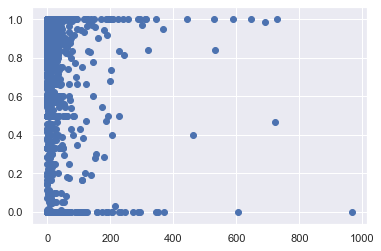

In [36]:
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);